In [1]:
import random
import csv

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from matplotlib import pyplot as plt
import sys
from scipy.signal import find_peaks
from tqdm import tqdm

from utils.eval.eval_utils import evaluate_peaks, compute_ROC
from utils.training.metrics import accuracy_for_segmenter, AUC_for_segmenter
from utils.training.data_loading import lines_to_line_generator, get_line_to_spectro_seg
from utils.training.keras_models import time_segmenter_model

2023-12-05 14:57:40.514553: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 14:57:40.556081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 14:57:40.556118: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 14:57:40.556143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 14:57:40.561824: I tensorflow/core/platform/cpu_feature_g

In [2]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/spectrograms"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/OHASISBIO_2020/spectrograms"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/HYDROMOMAR_2013/spectrograms"
BATCH_SIZE = 64
CHECKPOINT = "/media/plerolland/LaBoite/PublicData/trainings/checkpoints_auc_acc/checkpoints_seg/all/cp-0023.ckpt"

SIZE = (128, 186)  # number of pixels in the spectrograms
CHANNELS = 1  # 1 means grayscale 3 RGB
DURATION_S = 100  # duration of the spectrograms in s
OBJECTIVE_CURVE_WIDTH = 10  # defines dispersion of objective function in s

ALLOWED_ERROR_S = 10  # tolerance when evaluating and time distance allowed between two peaks in the probabilities distribution
MIN_PROBA = 0.0005  # minimum value of the output of the segmenter model to record it
TIME_RES = SIZE[1] / DURATION_S

data_loader = get_line_to_spectro_seg(size=SIZE, duration_s=DURATION_S, channels=CHANNELS, objective_curve_width=OBJECTIVE_CURVE_WIDTH)
model = time_segmenter_model
m = model()
m.load_weights(CHECKPOINT)
m.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(),
            loss=tf.losses.binary_crossentropy,
            metrics=[accuracy_for_segmenter, AUC_for_segmenter()])

In [3]:
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
print(len(lines), "files found")
generator = lines_to_line_generator(lines, repeat=False)
dataset =tf.data.Dataset.from_generator(lambda: map(tuple, generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string))
dataset = dataset.map(data_loader).batch(batch_size=BATCH_SIZE)

20736 files found


2023-12-05 14:57:50.176859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 14:57:50.204906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 14:57:50.205056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [114]:
history = m.evaluate(dataset)

generator = lines_to_line_generator(lines, repeat=False)
dataset =tf.data.Dataset.from_generator(lambda: map(tuple, generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string))
dataset = dataset.map(data_loader).batch(batch_size=BATCH_SIZE)

324/324 [==============================] - 55s 164ms/step - loss: 0.0282 - accuracy_for_segmenter: 0.9424 - auc_for_segmenter_7: 0.9093


In [4]:
detected_peaks = []
ground_truth_peaks = []

for images, y in tqdm(dataset, total=1+int(len(lines)/BATCH_SIZE)):
    predicted = m.predict(images, verbose=False)
    for i, p in enumerate(predicted):
        detected_peaks.append(find_peaks(p, height=MIN_PROBA, distance=ALLOWED_ERROR_S*TIME_RES))
        _y = y[i,:,0] if len(y.shape) == 3 else y[i, :]
        ground_truth_peaks.append(find_peaks(_y, height=MIN_PROBA, distance=ALLOWED_ERROR_S*TIME_RES))
        
detected_peaks = [[(d[0][i]/TIME_RES, d[1]["peak_heights"][i]) for i in range(len(d[0]))] for d in detected_peaks]
ground_truth_peaks = [d[0]/TIME_RES for d in ground_truth_peaks]

  0%|          | 0/325 [00:00<?, ?it/s]2023-12-05 14:57:58.842601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-05 14:57:59.377190: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-05 14:57:59.801689: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-05 14:58:02.290980: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-05 14:58:02.978449: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot sp

In [17]:
i,j = 0,0
for idx in range(len(detected_peaks)):
    i+=len(detected_peaks[idx])
    j+=len(ground_truth_peaks[idx])
print(f"{i} peaks found out of {j}")

128715 peaks found out of 1371


In [18]:
TP, FP, TP_per_seg, TN_per_seg, FP_per_seg, FN_per_seg, P_per_seg, N_per_seg = evaluate_peaks(ground_truth_peaks, detected_peaks, ALLOWED_ERROR_S)

In [19]:
print(len(TP), FP)
print(len(TP_per_seg), TN_per_seg, len(FP_per_seg), FN_per_seg, P_per_seg, N_per_seg)

1287 44883
1200 0 19536 0 1200 19536


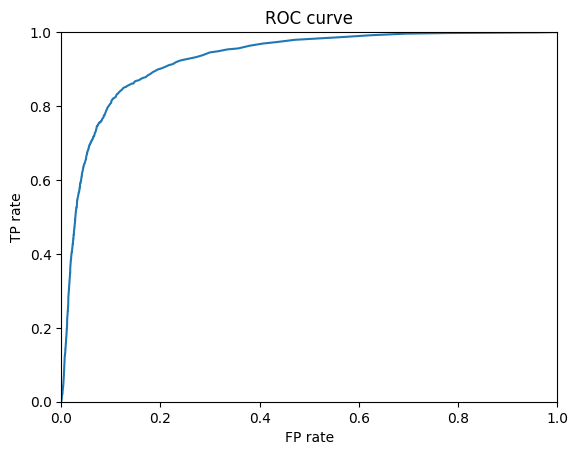

In [20]:
TPr, FPr = compute_ROC(TP_per_seg, P_per_seg, FP_per_seg, N_per_seg, thresh_delta=0.001)
plt.plot(FPr, TPr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.title("ROC curve")
plt.savefig("2Dto1D_ROC.png")

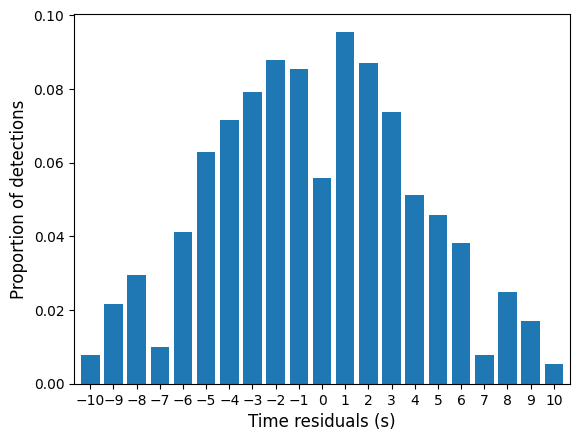

In [21]:
BAR_WIDTH = 0.8

allowed_d = list(range(-ALLOWED_ERROR_S, ALLOWED_ERROR_S+1))
TP_by_distance = {i : 0 for i in allowed_d}
for p in TP:
    thresh_s = np.round(p[1]).astype(np.int16)
    TP_by_distance[thresh_s] += 1
TP_by_distance = np.array(list(TP_by_distance.values())) / len(TP)

plt.bar(allowed_d, TP_by_distance, width=BAR_WIDTH, align='center')
plt.xticks(allowed_d)
plt.xlim(allowed_d[0]-0.5-(1-BAR_WIDTH), allowed_d[-1]+0.5+(1-BAR_WIDTH))

plt.xlabel('Time residuals (s)', fontsize=12)
plt.ylabel('Proportion of detections', fontsize=12)
plt.savefig('histogram_cnnseg_oha2020.png', bbox_inches='tight')